In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import gutenberg, stopwords
from collections import Counter

Supervised NLP requires a pre-labelled dataset for training and testing, and is generally interested in categorizing text in various ways. In this case, we are going to try to predict whether a sentence comes from _Alice in Wonderland_ by Lewis Carroll or _Persuasion_ by Jane Austen. We can use any of the supervised models we've covered previously, as long as they allow categorical outcomes. In this case, we'll try Random Forests, SVM, and KNN.

Our feature-generation approach will be something called _BoW_, or _Bag of Words_. BoW is quite simple: For each sentence, we count how many times each word appears. We will then use those counts as features.  

In [3]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

In [4]:
# Utility function to create a list of the 2000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(2000)]
    

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

In [5]:
# Load and clean the data.
persuasion = gutenberg.raw('austen-persuasion.txt')
alice = gutenberg.raw('carroll-alice.txt')

# The Chapter indicator is idiosyncratic
persuasion = re.sub(r'Chapter \d+', '', persuasion)
alice = re.sub(r'CHAPTER \*+', '', alice)
    
alice = text_cleaner(alice)
persuasion = text_cleaner(persuasion)

In [6]:
# Parse the cleaned novels. This can take a bit.
nlp = spacy.load('en')
alice_doc = nlp(alice)
persuasion_doc = nlp(persuasion)

In [8]:
# Group into sentences.
persuasion_sents = [[sent, "Austen"] for sent in persuasion_doc.sents]
alice_sents = [[sent, "Carroll"] for sent in alice_doc.sents]

# Combine the sentences from the two novels into one data frame.
sentences = pd.DataFrame(alice_sents + persuasion_sents)
sentences.head()

,0,1
0,"(CHAPTER, I., Down, the, Rabbit, -, Hole, Alic...",Carroll
1,"(So, she, was, considering, in, her, own, mind...",Carroll
2,"(There, was, nothing, so, VERY, remarkable, in...",Carroll
3,"(Oh, dear, !, I, shall, be, late, !, ', (, whe...",Carroll
4,"(In, another, moment, down, went, Alice, after...",Carroll


Time to bag some words!  Since spaCy has already tokenized and labelled our data, we can move directly to recording how often various words occur.  We will exclude stopwords and punctuation.  In addition, in an attempt to keep our feature space from exploding, we will work with lemmas (root words) rather than the raw text terms, and we'll only use the 2000 most common words for each text.

In [9]:
# Set up the bags.
alicewords = bag_of_words(alice_doc)
persuasionwords = bag_of_words(persuasion_doc)

# Combine bags to create a set of unique words.
common_words = set(alicewords + persuasionwords)

In [10]:
# Create our data frame with features. This can take a while to run.
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 4000
Processing row 4500


,busily,game,modern,astonished,impatiently,unable,agitation,deference,disgrace,horse,...,giddy,performance,agreement,cordial,sentiment,remarkable,midst,handwriting,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(CHAPTER, I., Down, the, Rabbit, -, Hole, Alic...",Carroll
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(So, she, was, considering, in, her, own, mind...",Carroll
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,"(There, was, nothing, so, VERY, remarkable, in...",Carroll
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Oh, dear, !, I, shall, be, late, !, ', (, whe...",Carroll
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(In, another, moment, down, went, Alice, after...",Carroll


## Trying out BoW

Now let's give the bag of words features a whirl by trying a random forest.

In [11]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier()
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.991199119912

Test set score: 0.923584387026


Holy overfitting, Batman! Overfitting is a known problem when using bag of words, since it basically involves throwing a massive number of features at a model – some of those features (in this case, word frequencies) will capture noise in the training set. Since overfitting is also a known problem with Random Forests, the divergence between training score and test score is expected.


## BoW with Logistic Regression

Let's try a technique with some protection against overfitting due to extraneous features – logistic regression with lasso.

In [12]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

(2727, 3039) (2727,)
Training set score: 0.965529886322

Test set score: 0.928532160528


Logistic regression performs a bit better than the random forest.  

# BoW with Gradient Boosting

And finally, let's see what gradient boosting can do:

In [13]:
clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))

Training set score: 0.918958562523

Test set score: 0.899945024739


Looks like logistic regression is the winner, but there's room for improvement.

# Same model, new inputs

What if we feed the model a different novel by Jane Austen, like _Emma_?  Will it be able to distinguish Austen from Carroll with the same level of accuracy if we insert a different sample of Austen's writing?

First, we need to process _Emma_ the same way we processed the other data, and combine it with the Alice data:

In [14]:
# Clean the Emma data.
emma = gutenberg.raw('austen-emma.txt')
emma = re.sub(r'VOLUME \w+', '', emma)
emma = re.sub(r'CHAPTER \w+', '', emma)
emma = text_cleaner(emma)
print(emma[:100])

Emma Woodhouse, handsome, clever, and rich, with a comfortable home and happy disposition, seemed to


In [15]:
# Parse our cleaned data.
emma_doc = nlp(emma)

In [16]:
# Group into sentences.
persuasion_sents = [[sent, "Austen"] for sent in persuasion_doc.sents]
emma_sents = [[sent, "Austen"] for sent in emma_doc.sents]

# Emma is quite long, let's cut it down to the same length as Alice.
emma_sents = emma_sents[0:len(alice_sents)]

In [17]:
# Build a new Bag of Words data frame for Emma word counts.
# We'll use the same common words from Alice and Persuasion.
emma_sentences = pd.DataFrame(emma_sents)
emma_bow = bow_features(emma_sentences, common_words)

print('done')

Processing row 0
Processing row 500
Processing row 1000
done


In [18]:
# Now we can model it!
# Let's use logistic regression again.

# Combine the Emma sentence data with the Alice data from the test set.
X_Emma_test = np.concatenate((
    X_train[y_train[y_train=='Carroll'].index],
    emma_bow.drop(['text_sentence','text_source'], 1)
), axis=0)
y_Emma_test = pd.concat([y_train[y_train=='Carroll'],
                         pd.Series(['Austen'] * emma_bow.shape[0])])

# Model.
print('\nTest set score:', lr.score(X_Emma_test, y_Emma_test))
lr_Emma_predicted = lr.predict(X_Emma_test)
pd.crosstab(y_Emma_test, lr_Emma_predicted)


Test set score: 0.699311805188


col_0,Austen,Carroll
row_0,,
Austen,1156,29
Carroll,539,165


Well look at that!  NLP approaches are generally effective on the same type of material as they were trained on. It looks like this model is actually able to differentiate multiple works by Austen from Alice in Wonderland.  Now the question is whether the model is very good at identifying Austen, or very good at identifying Alice in Wonderland, or both...

# Challenge 0:

Recall that the logistic regression model's best performance on the test set was 93%.  See what you can do to improve performance.  Suggested avenues of investigation include: Other modeling techniques (SVM?), making more features that take advantage of the spaCy information (include grammar, phrases, POS, etc), making sentence-level features (number of words, amount of punctuation), or including contextual information (length of previous and next sentences, words repeated from one sentence to the next, etc), and anything else your heart desires.  Make sure to design your models on the test set, or use cross_validation with multiple folds, and see if you can get accuracy above 97%.  

# SVM:
Well SCM performed significantly worse than the others, lets try adding some new features to a new train and test set and see if we can make any improvements.

In [19]:
from sklearn.svm import SVC

scv = SVC()
train = scv.fit(X_train, y_train)

print('Training set score:', scv.score(X_train, y_train))
print('\nTest set score:', scv.score(X_test, y_test))

Training set score: 0.742207554089

Test set score: 0.736118746564


# Add Sentence Length and Avg Word Length as a feature:

In [20]:
avg_wrd_len = [len(word_counts['text_sentence'][i].string)/
               len(word_counts['text_sentence'][i].string.split()) 
               for i in range (len(word_counts['text_sentence']))]

In [21]:
wrdspersent = [len(word_counts['text_sentence'][i].string.split()) 
               for i in range (len(word_counts['text_sentence']))]

In [22]:
import string
count = lambda l1,l2: sum([1 for x in l1 if x in l2])
punccount = [count(word_counts['text_sentence'][i].string,set(string.punctuation))     
    for i in range (len(word_counts['text_sentence']))]

In [24]:
def count_pos(sent, pos):
    sentenc = nlp(sent.string)
    i = 0
    for token in sentenc:
        if token.pos_ == pos:
            i+=1
    return i

In [25]:
def speech_part(sent, part):
    print('doing {}s'.format(part))
    return [count_pos(word_counts['text_sentence'][i], part)
        for i in range (len(word_counts['text_sentence']))]

In [26]:
def compare_feature(feature):
    plt.hist(features[feature][features.text_source == 'Austen'], label = 'Austen', normed = True, alpha = 0.5)
    plt.hist(features[feature][features.text_source == 'Carroll'], label = 'Carroll', normed = True, alpha = 0.5)
    plt.title('The {} feature frequency between the authors.'.format(feature))
    plt.xlabel(feature)
    plt.ylabel('frequency')
    plt.legend()
    plt.show()

In [27]:
list_pos = []
for token in nlp(word_counts['text_sentence'][0].string):
    list_pos.append(token.pos_)
list_pos = set(list_pos)
list_pos

{'ADJ',
 'ADP',
 'ADV',
 'CCONJ',
 'DET',
 'NOUN',
 'PART',
 'PRON',
 'PROPN',
 'PUNCT',
 'VERB'}

So we want to create a unique feature for all the above unqiue parts of speech

In [28]:
adj_count = speech_part(word_counts['text_sentence'], 'ADJ')
adp_count = speech_part(word_counts['text_sentence'], 'ADP')
adv_count = speech_part(word_counts['text_sentence'], 'ADV')
cconj_count = speech_part(word_counts['text_sentence'], 'CCONJ')
det_count = speech_part(word_counts['text_sentence'], 'DET')
noun_count = speech_part(word_counts['text_sentence'], 'NOUN')
part_count = speech_part(word_counts['text_sentence'], 'PART')
pron_count = speech_part(word_counts['text_sentence'], 'PRON')
verb_count = speech_part(word_counts['text_sentence'], 'VERB')

doing ADJs
doing ADPs
doing ADVs
doing CCONJs
doing DETs
doing NOUNs
doing PARTs
doing PRONs
doing VERBs


In [29]:
from textblob import TextBlob
polarity = []
subjectivity = []
for i in range (len(word_counts['text_sentence'])):
    s = TextBlob(word_counts['text_sentence'][i].string)
    polarity.append(s.sentiment.polarity)
    subjectivity.append(s.sentiment.subjectivity)

In [30]:
features = word_counts
features['avg_wrd_len']=avg_wrd_len
features['wrdspersent']=wrdspersent
features['punccount']=punccount
features['adj_count']=adj_count
features['adp_count']=adp_count
features['adv_count']=adv_count
features['cconj_count']=cconj_count
features['det_count']=det_count
features['noun_count']=noun_count
features['part_count']=part_count
features['pron_count']=pron_count
features['verb_count']=verb_count
features['polarity']=polarity
features['subjectivity']=subjectivity

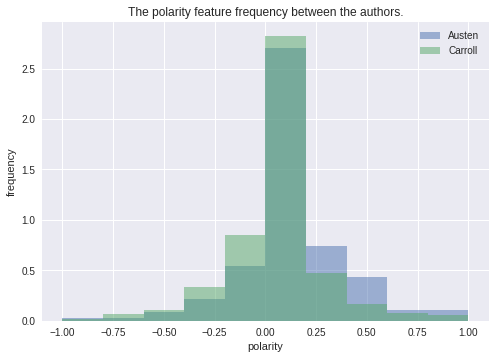

In [31]:
compare_feature('polarity')

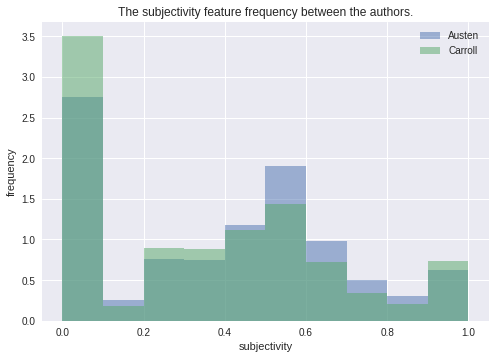

In [32]:
compare_feature('subjectivity')

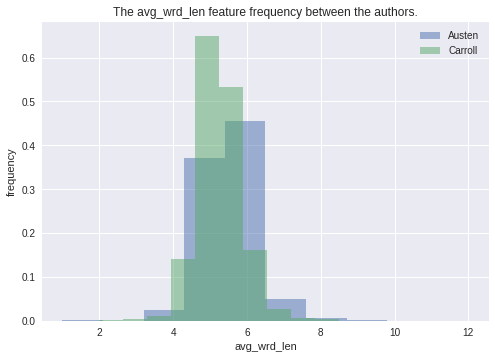

In [33]:
compare_feature('avg_wrd_len')

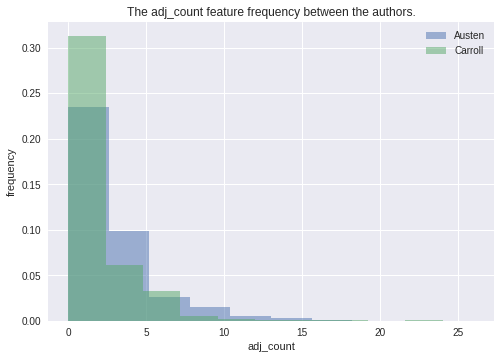

In [34]:
compare_feature('adj_count')


Just looking at the data that we collected it doesn't seem like most of what we collected features for shows any significant difference between the two authors.

# Test accuracy adding new features:

In [35]:
Y = features['text_source']
X = np.array(features.drop(['text_sentence','text_source'], 1))
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4)

In [36]:
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

(2727, 3053) (2727,)
Training set score: 0.965529886322

Test set score: 0.926333150082


Well, there doesnt seem to be any improvement dispire adding a ton of new features.

In [37]:
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.989365603227

Test set score: 0.877405167675


In [38]:
train = clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))

Training set score: 0.928492849285

Test set score: 0.899395272128


# Challenge 1:
Find out whether your new model is good at identifying Alice in Wonderland vs any other work, Persuasion vs any other work, or Austen vs any other work.  This will involve pulling a new book from the Project Gutenberg corpus (print(gutenberg.fileids()) for a list) and processing it.

Record your work for each challenge in a notebook and submit it below.

In [39]:
print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [40]:
dick = gutenberg.raw('melville-moby_dick.txt')
paradise = gutenberg.raw('milton-paradise.txt')

In [41]:
paradise = re.sub(r'Book .*', '', paradise)
dick = re.sub(r'CHAPTER .*', '', dick)

In [42]:
paradise = text_cleaner(paradise)
dick = text_cleaner(dick)

In [43]:
# Parse the cleaned novels. This can take a bit.
paradise_doc = nlp(paradise)
dick_doc = nlp(dick)

In [44]:
# Group into sentences.
paradise_sents = [[sent, "Milton"] for sent in paradise_doc.sents]
dick_sents = [[sent, "Melville"] for sent in dick_doc.sents]

# Combine the sentences from the two novels into one data frame.
sentences = pd.DataFrame(paradise_sents + dick_sents)
sentences.head()

,0,1
0,"(Of, Man, 's, first, disobedience, ,, and, the...",Milton
1,"(And, chiefly, thou, ,, O, Spirit, ,, that, do...",Milton
2,"(Say, first, for, Heaven, hides, nothing, from...",Milton
3,"(his, will, For, one, restraint, ,, lords, of,...",Milton
4,"(Who, first, seduced, them, to, that, foul, re...",Milton


In [46]:
# Set up the bags.
paradisewords = bag_of_words(paradise_doc)
dickwords = bag_of_words(dick_doc)

# Combine bags to create a set of unique words.
common_words = set(paradisewords + dickwords)

In [47]:
# Create our data frame with features. This can take a while to run.
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 4000
Processing row 4500
Processing row 5000
Processing row 5500
Processing row 6000
Processing row 6500
Processing row 7000
Processing row 7500
Processing row 8000
Processing row 8500
Processing row 9000
Processing row 9500
Processing row 10000
Processing row 10500


,game,modern,intend,horse,fore,ne,involuntarily,feed,rod,absolute,...,gain,reveal,pure,upward,remarkable,pervert,eastern,midst,text_sentence,text_source
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Of, Man, 's, first, disobedience, ,, and, the...",Milton
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,"(And, chiefly, thou, ,, O, Spirit, ,, that, do...",Milton
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Say, first, for, Heaven, hides, nothing, from...",Milton
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(his, will, For, one, restraint, ,, lords, of,...",Milton
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Who, first, seduced, them, to, that, foul, re...",Milton


In [49]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier()
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.992156259612

Test set score: 0.903114186851


Standard BOW roughly the same as before.  Now add my features.

In [50]:
avg_wrd_len = [len(word_counts['text_sentence'][i].string)/
               len(word_counts['text_sentence'][i].string.split()) 
               for i in range (len(word_counts['text_sentence']))]

wrdspersent = [len(word_counts['text_sentence'][i].string.split()) 
               for i in range (len(word_counts['text_sentence']))]

punccount = [count(word_counts['text_sentence'][i].string,set(string.punctuation))     
    for i in range (len(word_counts['text_sentence']))]

adj_count = speech_part(word_counts['text_sentence'], 'ADJ')
adp_count = speech_part(word_counts['text_sentence'], 'ADP')
adv_count = speech_part(word_counts['text_sentence'], 'ADV')
cconj_count = speech_part(word_counts['text_sentence'], 'CCONJ')
det_count = speech_part(word_counts['text_sentence'], 'DET')
noun_count = speech_part(word_counts['text_sentence'], 'NOUN')
part_count = speech_part(word_counts['text_sentence'], 'PART')
pron_count = speech_part(word_counts['text_sentence'], 'PRON')
verb_count = speech_part(word_counts['text_sentence'], 'VERB')

from textblob import TextBlob
polarity = []
subjectivity = []
for i in range (len(word_counts['text_sentence'])):
    s = TextBlob(word_counts['text_sentence'][i].string)
    polarity.append(s.sentiment.polarity)
    subjectivity.append(s.sentiment.subjectivity)

doing ADJs
doing ADPs
doing ADVs
doing CCONJs
doing DETs
doing NOUNs
doing PARTs
doing PRONs
doing VERBs


In [51]:
features = word_counts
features['avg_wrd_len']=avg_wrd_len
features['wrdspersent']=wrdspersent
features['punccount']=punccount
features['adj_count']=adj_count
features['adp_count']=adp_count
features['adv_count']=adv_count
features['cconj_count']=cconj_count
features['det_count']=det_count
features['noun_count']=noun_count
features['part_count']=part_count
features['pron_count']=pron_count
features['verb_count']=verb_count
features['polarity']=polarity
features['subjectivity']=subjectivity

In [52]:
Y = features['text_source']
X = np.array(features.drop(['text_sentence','text_source'], 1))
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4)

In [53]:
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.991079667795

Test set score: 0.895501730104


In [54]:
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

(6502, 3055) (6502,)
Training set score: 0.977852968317

Test set score: 0.947404844291


In [55]:
def compare_featureMII(feature):
    plt.hist(features[feature][features.text_source == 'Milton'], label = 'Milton', normed = True, alpha = 0.5)
    plt.hist(features[feature][features.text_source == 'Melville'], label = 'Melville', normed = True, alpha = 0.5)
    plt.title('The {} feature frequency between the authors.'.format(feature))
    plt.xlabel(feature)
    plt.ylabel('frequency')
    plt.legend()
    plt.show()

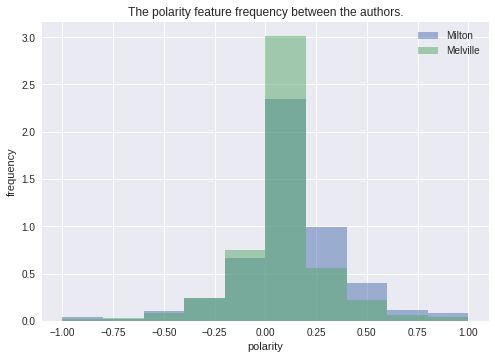

In [56]:
compare_featureMII('polarity')

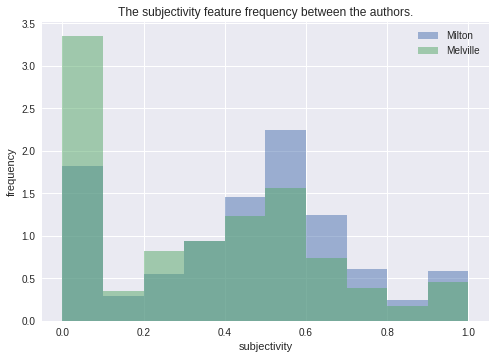

In [57]:
compare_featureMII('subjectivity')

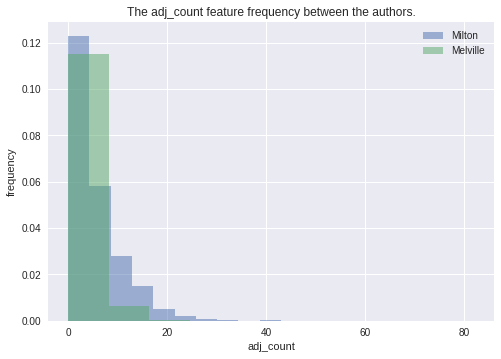

In [58]:
compare_featureMII('adj_count')

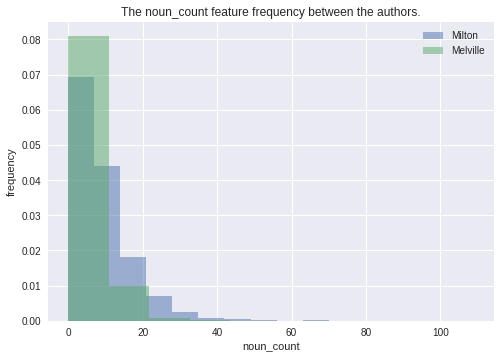

In [59]:
compare_featureMII('noun_count')

# Results

LR performed slightly better on these two works than on Alice and Persuasion.  Likely due to the training and test sets being bigger.  Nothing jumps out about the feature sets that would distinguish one work from the other more than in the Persuasion and Alice case.  94.7% isn't bad though.